In [1]:
# Import statements
import docplex
from docplex.mp.model import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [41]:
day = '2024-08-14'

prices = pd.read_csv('energy prices_Germany_week 33 2024.csv')
prices.columns = prices.iloc[0]
prices.drop(prices.iloc[:2].index, inplace=True)

prices_day = prices[prices['Date (GMT+2)'].str.contains(day, na=False)]
prices_day['Day Ahead Auction (DE-LU)'] = pd.to_numeric(prices_day['Day Ahead Auction (DE-LU)'], errors='coerce')
prices_day['Day Ahead Auction (DE-LU)'].values.tolist()


/var/folders/hv/5rn9tnkj70x5xkjrsjhdxj9w0000gn/T/ipykernel_99919/2735869037.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_day['Day Ahead Auction (DE-LU)'] = pd.to_numeric(prices_day['Day Ahead Auction (DE-LU)'], errors='coerce')


[87.73,
 90.79,
 87.73,
 93.4,
 93.6,
 107.1,
 129.74,
 136.62,
 120.96,
 108.79,
 83.08,
 77.24,
 72.85,
 75.38,
 74.71,
 81.74,
 94.36,
 105.59,
 111.48,
 161.41,
 218.92,
 148.7,
 120.43,
 109.95]

## Defining the model class

In [42]:
class PSH(Model):


    def __init__(self):
        super().__init__()

        # Indices
        self.reservoirs = np.arange(3) # For modelling reasons 3 reserviors are implemented, where the last reservoir is the river Kunhar
        self.hydro_units = np.arange(1)
        self.hu_affiliation = {
            0: [],
            1: [0],
            2: []
        }
        self.pumped_storage_units = np.arange(1)
        self.ps_affiliation = {
            0: [0],
            1: [],
            2: []
        }
        self.periods = np.arange(24)
        self.subregions = np.arange(10)
        self.vertices = np.arange(3)

        # Reservoir parameters
        self.initial_volume = {
            0: 1500000,
            1: 1500000,
            2: 10000000
        }
        self.min_terminal_volume = {
            0: 1500000,
            1: 1500000,
            2: 1,
        }
        self.natural_inflow = pd.DataFrame(index=self.reservoirs, columns=self.periods)
        self.natural_inflow.loc[0:,] = 8.66
        self.natural_inflow.loc[1:,] = 86.6
        self.natural_inflow.loc[2:,] = 0
        self.spillage = pd.DataFrame(data=5, index=self.reservoirs, columns=self.periods)

        # Volume limits
        self.volume_limits = pd.DataFrame(index=['max', 'min'], columns=self.reservoirs)
        self.volume_limits.loc['max',0] = 2750000
        self.volume_limits.loc['min',0] = 1000000
        self.volume_limits.loc['max',1] = 2566000
        self.volume_limits.loc['min',1] = 1000000
        self.volume_limits.loc['max',2] = 1000000000
        self.volume_limits.loc['min',2] = 1

        # Getting the energyprices
        self.day = '2024-08-14'
        prices = pd.read_csv('energy prices_Germany_week 33 2024.csv') # Reading the data
        prices.columns = prices.iloc[0] # Fixing wrong headers
        prices.drop(prices.iloc[:2].index, inplace=True)
        prices_day = prices[prices['Date (GMT+2)'].str.contains(self.day, na=False)] # Filter data for the anyzed day
        prices_day['Day Ahead Auction (DE-LU)'] = pd.to_numeric(prices_day['Day Ahead Auction (DE-LU)'], errors='coerce') # Changing the data type to float
        self.projected_prices = prices_day['Day Ahead Auction (DE-LU)'].values.tolist()

        # Perid length
        self.period_length = 1

        # Pumping consumption of the pumped-storage units
        self.pumping_consumption = {
            0: 9,
        }
        
        # Pumping limits pumped-storage units
        self.ps_discharge_pumping_limits = pd.DataFrame(index=['max', 'min'], columns=self.pumped_storage_units)
        self.ps_discharge_pumping_limits.loc['max':,] = 22
        self.ps_discharge_pumping_limits.loc['min':,] = 10

        # Linearization
        # Hydro units
        self.hu_head_limits = pd.DataFrame(index=['max', 'min'], columns=self.hydro_units)
        self.hu_head_limits.loc['max':,] = 218
        self.hu_head_limits.loc['min':,] = 200

        self.hu_discharge_limits = pd.DataFrame(index=['max', 'min'], columns=self.hydro_units)
        self.hu_discharge_limits.loc['max':,] = 154
        self.hu_discharge_limits.loc['min':,] = 50

        # Pumped-storage units
        self.ps_head_limits = pd.DataFrame(index=['max', 'min'], columns=self.pumped_storage_units)
        self.ps_head_limits.loc['max':,] = 770
        self.ps_head_limits.loc['min':,] = 750

        self.ps_discharge_generation_limits = pd.DataFrame(index=['max', 'min'], columns=self.pumped_storage_units)
        self.ps_discharge_generation_limits.loc['max':,] = 32
        self.ps_discharge_generation_limits.loc['min':,] = 5

        # Empty lists for the vertices
        self.hu_h_vertices = []
        self.hu_q_vertices = []
        self.hu_p_vertices = []

        self.ps_h_vertices = []
        self.ps_q_vertices = []
        self.ps_p_vertices = []

        # Head parameters
        self.hu_head_zero = {
            0: 187.21
        }
        self.hu_head_coefficient = {
            0: 0.000012
        }
        self.ps_head_zero = {
            0: 739.75
        }
        self.ps_head_coefficient = {
            0: 0.000011
        }

        # Efficiencies
        self.hu_effciency = {
            0: 0.9123
        }
        self.ps_efficiency_gen = {
            0: 0.8547
        }
        self.ps_efficiency_pump = {
            0: 0.8975
        }

        # Max Power
        self.hu_max_power = {
            0: 300
        }
        self.ps_max_power = {
            0: 200
        }

    
    # Method to calculate the head vertices for the linearization
    def head_vertices(self, units: list, affiliation: dict, limits: pd.DataFrame) -> list:

        #Defining a 4-dimensional array
        vertice_values = np.zeros([len(self.reservoirs), len(units), len(self.subregions), len(self.vertices)])
        
        for i in self.reservoirs:
            for j in affiliation[i]:

                # Dividing the water head into equally large intervals, that fill the domain
                head_interval = (limits.loc['max',j] - limits.loc['min',j]) / (len(self.subregions) / 2)
                for l in self.subregions:
                    if l % 2 == 0: # Defining the coordonates of 2 trangles in 1 itteration

                        # First triangle
                        vertice_values[i,j,l,0] = limits.loc['min',j] + l / 2 * head_interval # bottom left
                        vertice_values[i,j,l,1] = limits.loc['min',j] + l / 2 * head_interval + head_interval # bottom right
                        vertice_values[i,j,l,2] = vertice_values[i,j,l,0] # top left

                        # Secon triangle
                        vertice_values[i,j,l+1,0] = vertice_values[i,j,l,0] # top left
                        vertice_values[i,j,l+1,1] = vertice_values[i,j,l,1]# top right
                        vertice_values[i,j,l+1,2] = vertice_values[i,j,l,1] # bottom right

        return vertice_values
    

    # Method to calculate the discharge vertrices for the linearization
    def discharge_vertices(self, units: list, affiliation: dict, limits: pd.DataFrame) -> list:

        #Defining a 4-dimensional array
        vertice_values = np.zeros([len(self.reservoirs), len(units), len(self.subregions), len(self.vertices)])

        for i in self.reservoirs:
            for j in affiliation[i]:
                for l in self.subregions:
                    if l % 2 == 0: # Defining the coordonates of 2 triangles in 1 itteration
                        vertice_values[i,j,l,0] = limits.loc['min',j] # bottom left
                        vertice_values[i,j,l,1] = limits.loc['min',j] # bottom right
                        vertice_values[i,j,l,2] = limits.loc['max',j] # top left

                        vertice_values[i,j,l+1,0] = limits.loc['max',j] # top left
                        vertice_values[i,j,l+1,1] = limits.loc['max',j] # top right
                        vertice_values[i,j,l+1,2] = limits.loc['min',j] # bottom right
        
        return vertice_values
    

    # Method to calculate the power vertices for the linearization
    def power_vertices(self, units: list, affiliation: dict, h_vertices: list, q_vertices: list, efficiency: dict) -> list:

        #Defining a 4-dimensional array
        vertice_values = np.zeros([len(self.reservoirs), len(units), len(self.subregions), len(self.vertices)])
        
        for i in self.reservoirs:
            for j in affiliation[i]:
                for l in self.subregions:
                    for r in self.vertices:

                        # Applying the formula
                        vertice_values[i,j,l,r] = 9.81 * (10 ** -3) * efficiency[j] * h_vertices[i,j,l,r] * q_vertices[i,j,l,r]

        return vertice_values
    

    # Method to define the decision variabels
    def define_decision_variables(self):
        self.clear()

        # Reservoir decision variables
        self.volume = self.continuous_var_matrix(self.reservoirs, self.periods, name='volume')
        self.total_discharge = self.continuous_var_matrix(self.reservoirs, self.periods, name='total_discharge')

        # Hydro unit decision variables
        self.hu_discharge = self.continuous_var_cube(self.reservoirs, self.hydro_units, self.periods, name='hu_discharge')
        self.hu_head = self.continuous_var_cube(self.reservoirs, self.hydro_units, self.periods, name='hu_head')
        self.hu_power = self.continuous_var_cube(self.reservoirs, self.hydro_units, self.periods, name='hu_power')
        self.hu_active_subregion = self.binary_var_dict([(i, j, t, l) for i in self.reservoirs for j in self.hydro_units for t in self.periods for l in self.subregions], name='hu_active_subregion')
        self.hu_alpha_coefficient = self.continuous_var_dict([(i, j, t, l, r) for i in self.reservoirs for j in self.hydro_units for t in self.periods for l in self.subregions for r in self.vertices], name='hu_alpha_coefficient')

        # Pumped-storage unit decision variables
        self.ps_active_subregion = self.binary_var_dict([(i, k, t, l) for i in self.reservoirs for k in self.pumped_storage_units for t in self.periods for l in self.subregions], name='ps_active_subregion')
        self.ps_alpha_coefficient = self.continuous_var_dict([(i, k, t, l, r) for i in self.reservoirs for k in self.pumped_storage_units for t in self.periods for l in self.subregions for r in self.vertices], name='ps_alpha_coefficient')
        self.ps_head_gen = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_head_gen')
        self.ps_power_gen = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_power_gen')
        self.ps_power_pump = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_power_pump')
        self.ps_discharge_gen = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_discharge_gen')
        self.ps_discharge_pump = self.continuous_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_discharge_pump')
        self.ps_state_gen = self.binary_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_state_gen')
        self.ps_state_pump = self.binary_var_cube(self.reservoirs, self.pumped_storage_units, self.periods, name='ps_state_pump')


    # Method that defines the constraints of the model
    def define_contraints(self):
        self.clear_constraints()

        # (2) Water-balance constraint except of first reservoir and first period
        for i in self.reservoirs[1:]:
            for t in self.periods[1:]:
                self.add_constraint(self.volume[i,t] == self.volume[i,t-1] + 3600 * self.period_length * (self.natural_inflow.loc[i,t] - self.total_discharge[i,t] + self.total_discharge[i-1,t] - self.sum(self.ps_discharge_pump[i-1,k,t] for k in self.ps_affiliation[i-1]) + self.sum(self.ps_discharge_pump[i,k,t] for k in self.ps_affiliation[i])))

        # (2) Exception for first reservoir and all periods except of first period
        for t in self.periods[1:]:
            self.add_constraint(self.volume[0,t] == self.volume[0,t-1] + 3600 * self.period_length * (self.natural_inflow.loc[0,t] - self.total_discharge[0,t] + 0 - 0 + self.sum(self.ps_discharge_pump[0,k,t] for k in self.ps_affiliation[0]))) # No inflow from upstream reservoirs and no pumped water to upstream reservoirs for the first reservoir

        # Exceptions for first period ans all reservoirs
        self.add_constraint(self.volume[0,0] == self.initial_volume[0] + 3600 * self.period_length * (self.natural_inflow.loc[0,0] - self.total_discharge[0,0] + 0 - 0 + self.sum(self.ps_discharge_pump[0,k,0] for k in self.ps_affiliation[0]))) # No inflow from upstream reservoirs and no pumped water to upstream reservoirs for the first reservoir
        self.add_constraint(self.volume[1,0] == self.initial_volume[1] + 3600 * self.period_length * (self.natural_inflow.loc[1,0] - self.total_discharge[1,0] + self.total_discharge[1-1,0] - self.sum(self.ps_discharge_pump[0,k,0] for k in self.ps_affiliation[0]) + self.sum(self.ps_discharge_pump[1,k,0] for k in self.ps_affiliation[1]))) # No inflow from
        self.add_constraint(self.volume[2,0] == self.initial_volume[1] + 3600 * self.period_length * (self.natural_inflow.loc[2,0] - self.total_discharge[2,0] + self.total_discharge[2-1,0] - self.sum(self.ps_discharge_pump[1,k,0] for k in self.ps_affiliation[1]) + self.sum(self.ps_discharge_pump[2,k,0] for k in self.ps_affiliation[2])))

        # (3) Total discharge
        for i in self.reservoirs:
            for t in self.periods:
                self.add_constraint(self.total_discharge[i,t] == self.spillage.loc[i,t] + self.sum(self.hu_discharge[i,j,t] for j in self.hu_affiliation[i]) + self.sum(self.ps_discharge_gen[i,k,t] for k in self.ps_affiliation[i]))

        # (4) Water-level limits
        for i in self.reservoirs:
            for t in self.periods:
                self.add_constraint(self.volume[i,t] >= self.volume_limits.loc['min',i])
                self.add_constraint(self.volume[i,t] <= self.volume_limits.loc['max',i])

        # (5) Minimum terminal water level
        self.add_constraints(self.volume[i,len(self.periods)-1] >= self.min_terminal_volume[i] for i in self.reservoirs[:-1])

        # (8) At most one subregion can be active
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.sum(self.hu_active_subregion[i,j,t,l] for l in self.subregions) <= 1)

        # (9) Convex combination coefficients must sum up to 1 or 0
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        self.add_constraint(self.sum(self.hu_alpha_coefficient[i,j,t,l,r] for r in self.vertices) == self.hu_active_subregion[i,j,t,l])

        # (10) Non-negativity condition for convex combination coefficients
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        for r in self.vertices:
                            self.add_constraint(self.hu_alpha_coefficient[i,j,t,l,r] >= 0)

        # (11)-(13) Calculation of linearized water head, discharge, and power output
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.hu_head[i,j,t] == self.sum(self.sum(self.hu_alpha_coefficient[i,j,t,l,r] * self.hu_h_vertices[i,j,l,r] for r in self.vertices) for l in self.subregions)) # (11) water head
                    self.add_constraint(self.hu_discharge[i,j,t] == self.sum(self.sum(self.hu_alpha_coefficient[i,j,t,l,r] * self.hu_q_vertices[i,j,l,r] for r in self.vertices) for l in self.subregions)) # (12) discharge
                    self.add_constraint(self.hu_power[i,j,t] == self.sum(self.sum(self.hu_alpha_coefficient[i,j,t,l,r] * self.hu_p_vertices[i,j,l,r] for r in self.vertices) for l in self.subregions)) # (13) power

        # (14) Max Power constraint
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.hu_power[i,j,t] <= self.hu_max_power[j])

        # (15) Relation between water head and volume
        for i in self.reservoirs:
            for j in self.hu_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.hu_head[i,j,t] <= self.hu_head_zero[j] + self.hu_head_coefficient[j] * self.volume[i,t])

        # ----- Modified constraints (8)-(15) for pumped-storage units -----
        # At most one subregion can be active
        for i in self.reservoirs:
            for j in self.ps_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.sum(self.ps_active_subregion[i,j,t,l] for l in self.subregions) <= 1)

        # Convex combination coefficients must sum up to 1 or 0
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        self.add_constraint(self.sum(self.ps_alpha_coefficient[i,k,t,l,r] for r in self.vertices) == self.ps_active_subregion[i,k,t,l])

        # Non-negativity condition for convex combination coefficients
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    for l in self.subregions:
                        for r in self.vertices:
                            self.add_constraint(self.ps_alpha_coefficient[i,k,t,l,r] >= 0)

        # Calculation of linearized water head, discharge, and power output
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.ps_head_gen[i,k,t] == self.sum(self.sum(self.ps_alpha_coefficient[i,k,t,l,r] * self.ps_h_vertices[i,k,l,r] for r in self.vertices) for l in self.subregions)) # water head
                    self.add_constraint(self.ps_discharge_gen[i,k,t] == self.sum(self.sum(self.ps_alpha_coefficient[i,k,t,l,r] * self.ps_q_vertices[i,k,l,r] for r in self.vertices) for l in self.subregions)) # discharge
                    self.add_constraint(self.ps_power_gen[i,k,t] == self.sum(self.sum(self.ps_alpha_coefficient[i,k,t,l,r] * self.ps_p_vertices[i,k,l,r] for r in self.vertices) for l in self.subregions)) # power

        # Relation between water head and volume
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.ps_head_gen[i,k,t] <= self.ps_head_zero[k] + self.ps_head_coefficient[k] * self.volume[i,t])
        
        # Max Power constraint
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:
                    self.add_constraint(self.ps_power_gen[i,k,t] <= self.ps_max_power[k])

        # ----- End modified constraints (8)-(15) for pumped-storage units -----

        # (16)-(22) Pumped storage unit constraints
        for i in self.reservoirs:
            for k in self.ps_affiliation[i]:
                for t in self.periods:

                    # (16) state constraint
                    self.add_constraint(self.ps_state_gen[i,k,t] + self.ps_state_pump[i,k,t] <= 1)

                    # (17) generation constraints
                    self.add_constraint(self.ps_discharge_generation_limits.loc['min',k] * self.ps_state_gen[i,k,t] <= self.ps_discharge_gen[i,k,t])
                    self.add_constraint(self.ps_discharge_generation_limits.loc['max',k] * self.ps_state_gen[i,k,t] >= self.ps_discharge_gen[i,k,t])

                    # (18) Pumping constraints
                    self.add_constraint(self.ps_discharge_pumping_limits.loc['min',k] * self.ps_state_pump[i,k,t] <= self.ps_discharge_pump[i,k,t])
                    self.add_constraint(self.ps_discharge_pumping_limits.loc['max',k] * self.ps_state_pump[i,k,t] >= self.ps_discharge_pump[i,k,t])

                    # (19) Calculating power consumption based on pumped water
                    self.add_constraint(self.ps_power_pump[i,k,t] == self.ps_discharge_pump[i,k,t] * self.pumping_consumption[k] * (1/self.ps_efficiency_pump[k]))

    # Method to define the objective value and to solve the model
    def solve_model(self):
        J = self.sum(self.sum(self.projected_prices[t] * self.period_length * (self.sum(self.hu_power[i,j,t] for j in self.hu_affiliation[i]) + self.sum(self.ps_power_gen[i,k,t] for k in self.ps_affiliation[i]) - self.sum(self.ps_power_pump[i,k,t] for k in self.ps_affiliation[i])) for i in self.reservoirs) for t in self.periods)
        self.maximize(J)
        self.solve()
        

#### Validation the correct calculation of the vertices for the linearization

/var/folders/hv/5rn9tnkj70x5xkjrsjhdxj9w0000gn/T/ipykernel_99919/247343052.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_day['Day Ahead Auction (DE-LU)'] = pd.to_numeric(prices_day['Day Ahead Auction (DE-LU)'], errors='coerce') # Changing the data type to float


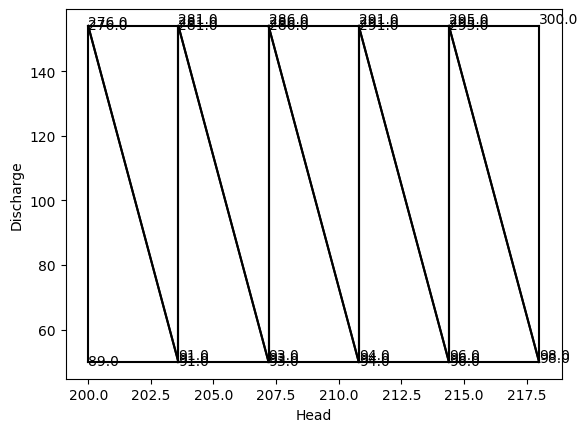

In [44]:
# Creating a model instance
psh = PSH()

# Calculating vertices
psh.hu_h_vertices = psh.head_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_head_limits)
psh.hu_q_vertices = psh.discharge_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_discharge_limits)
psh.hu_p_vertices = psh.power_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_h_vertices, psh.hu_q_vertices, psh.hu_effciency)

# Plotting the subregions in the domain
for i in psh.reservoirs:
    for j in psh.hu_affiliation[i]:

        fig, ax = plt.subplots()

        for l in psh.subregions:

            ax.plot([psh.hu_h_vertices[i,j,l,0], psh.hu_h_vertices[i,j,l,1]], [psh.hu_q_vertices[i,j,l,0], psh.hu_q_vertices[i,j,l,1]], color='black')
            ax.plot([psh.hu_h_vertices[i,j,l,1], psh.hu_h_vertices[i,j,l,2]], [psh.hu_q_vertices[i,j,l,1], psh.hu_q_vertices[i,j,l,2]], color='black')
            ax.plot([psh.hu_h_vertices[i,j,l,2], psh.hu_h_vertices[i,j,l,0]], [psh.hu_q_vertices[i,j,l,2], psh.hu_q_vertices[i,j,l,0]], color='black')

            # Setting the labels
            plt.annotate(round(psh.hu_p_vertices[i,j,l,0],0), xy=(psh.hu_h_vertices[i,j,l,0], psh.hu_q_vertices[i,j,l,0]), xytext=(psh.hu_h_vertices[i,j,l,0], psh.hu_q_vertices[i,j,l,0]-1))
            plt.annotate(round(psh.hu_p_vertices[i,j,l,1],0), xy=(psh.hu_h_vertices[i,j,l,1], psh.hu_q_vertices[i,j,l,1]), xytext=(psh.hu_h_vertices[i,j,l,1], psh.hu_q_vertices[i,j,l,1]+1))
            plt.annotate(round(psh.hu_p_vertices[i,j,l,2],0), xy=(psh.hu_h_vertices[i,j,l,2], psh.hu_q_vertices[i,j,l,2]), xytext=(psh.hu_h_vertices[i,j,l,2], psh.hu_q_vertices[i,j,l,2]))

            ax.set_ylabel('Discharge')
            ax.set_xlabel('Head')

/var/folders/hv/5rn9tnkj70x5xkjrsjhdxj9w0000gn/T/ipykernel_99919/247343052.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_day['Day Ahead Auction (DE-LU)'] = pd.to_numeric(prices_day['Day Ahead Auction (DE-LU)'], errors='coerce') # Changing the data type to float


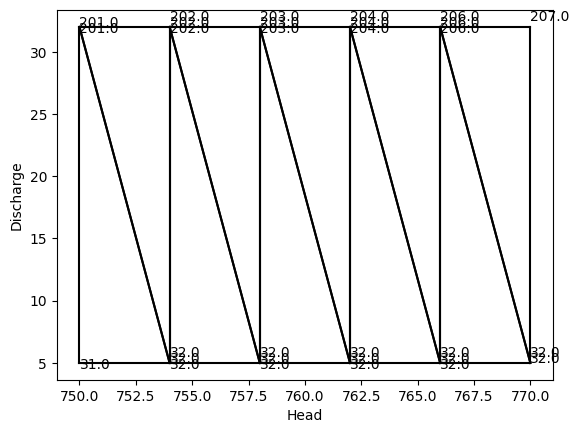

In [45]:
# Creating a model instance
psh = PSH()

# Calculating vertices
psh.ps_h_vertices = psh.head_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_head_limits)
psh.ps_q_vertices = psh.discharge_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_discharge_generation_limits)
psh.ps_p_vertices = psh.power_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_h_vertices, psh.ps_q_vertices, psh.ps_efficiency_gen)

for i in psh.reservoirs:
    for j in psh.ps_affiliation[i]:

        fig, ax = plt.subplots()

        for l in psh.subregions:

            ax.plot([psh.ps_h_vertices[i,j,l,0], psh.ps_h_vertices[i,j,l,1]], [psh.ps_q_vertices[i,j,l,0], psh.ps_q_vertices[i,j,l,1]], color='black')
            ax.plot([psh.ps_h_vertices[i,j,l,1], psh.ps_h_vertices[i,j,l,2]], [psh.ps_q_vertices[i,j,l,1], psh.ps_q_vertices[i,j,l,2]], color='black')
            ax.plot([psh.ps_h_vertices[i,j,l,2], psh.ps_h_vertices[i,j,l,0]], [psh.ps_q_vertices[i,j,l,2], psh.ps_q_vertices[i,j,l,0]], color='black')

            # Setting the labels
            plt.annotate(round(psh.ps_p_vertices[i,j,l,0],0), xy=(psh.ps_h_vertices[i,j,l,0], psh.ps_q_vertices[i,j,l,0]), xytext=(psh.ps_h_vertices[i,j,l,0], psh.ps_q_vertices[i,j,l,0]-0.5))
            plt.annotate(round(psh.ps_p_vertices[i,j,l,1],0), xy=(psh.ps_h_vertices[i,j,l,1], psh.ps_q_vertices[i,j,l,1]), xytext=(psh.ps_h_vertices[i,j,l,1], psh.ps_q_vertices[i,j,l,1]+0.5))
            plt.annotate(round(psh.ps_p_vertices[i,j,l,2],0), xy=(psh.ps_h_vertices[i,j,l,2], psh.ps_q_vertices[i,j,l,2]), xytext=(psh.ps_h_vertices[i,j,l,2], psh.ps_q_vertices[i,j,l,2]))

            ax.set_ylabel('Discharge')
            ax.set_xlabel('Head')

## Solving the model

In [46]:
# Creating a model instance
psh = PSH()

# Calculating the vertices
psh.hu_h_vertices = psh.head_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_head_limits)
psh.hu_q_vertices = psh.discharge_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_discharge_limits)
psh.hu_p_vertices = psh.power_vertices(psh.hydro_units, psh.hu_affiliation, psh.hu_h_vertices, psh.hu_q_vertices, psh.hu_effciency)

psh.ps_h_vertices = psh.head_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_head_limits)
psh.ps_q_vertices = psh.discharge_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_discharge_generation_limits)
psh.ps_p_vertices = psh.power_vertices(psh.pumped_storage_units, psh.ps_affiliation, psh.ps_h_vertices, psh.ps_q_vertices, psh.ps_efficiency_gen)

# Defining decision variables and constraints
psh.define_decision_variables()
psh.define_contraints()

# Solving the model
psh.solve_model()
print(psh.solve_details)
print(psh.objective_value)


/var/folders/hv/5rn9tnkj70x5xkjrsjhdxj9w0000gn/T/ipykernel_99919/247343052.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_day['Day Ahead Auction (DE-LU)'] = pd.to_numeric(prices_day['Day Ahead Auction (DE-LU)'], errors='coerce') # Changing the data type to float


status  = integer optimal, tolerance
time    = 1.20387 s.
problem = MILP
gap     = 0.00996361%

619892.6442973859


## Analyzing the Data

#### Alphas

In [6]:
x = np.zeros([len(psh.hydro_units), len(psh.periods), len(psh.subregions), len(psh.vertices)])
for j in psh.hydro_units:
    for t in psh.periods:
        for l in psh.subregions:
            for r in psh.vertices:
                x[j,t,l,r] = psh.hu_alpha_coefficient[0,j,t,l,r].solution_value

x

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
   

In [7]:
x = np.zeros([len(psh.pumped_storage_units), len(psh.periods), len(psh.subregions), len(psh.vertices)])
for k in psh.pumped_storage_units:
    for t in psh.periods:
        for l in psh.subregions:
            for r in psh.vertices:
                x[k,t,l,r] = psh.ps_alpha_coefficient[0,k,t,l,r].solution_value

x

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         

#### Results Table

In [47]:
# Creating a table containing the results
# The first number in the label is always the reservoir index and the second the unit index
results = pd.DataFrame(columns=psh.periods)

# Volume
for i in psh.reservoirs:
    for t in psh.periods:
        index = f'volume_{i}'
        results.loc[index,t] = psh.volume[i,t].solution_value

# Spillage
for i in psh.reservoirs:
    for t in psh.periods:
        index = f'spillage_{i}'
        results.loc[index] = psh.spillage.loc[i,t]

# Hydro unit discharge
for j in psh.hydro_units:
    for i in psh.reservoirs:
        if j in psh.hu_affiliation[i]:
            for t in psh.periods:
                index = f'hu_discharge_{i}_{j}'
                results.loc[index,t] = psh.hu_discharge[i,j,t].solution_value

# Pumped storage unit discharge for power generation
for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if k in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_discharge_gen_{i}_{k}'
                results.loc[index,t] = psh.ps_discharge_gen[i,k,t].solution_value

# Total discharge to downstream reservoirs
for i in psh.reservoirs:
    for t in psh.periods:
        index = f'total_discharge_{i}'
        results.loc[index,t] = psh.total_discharge[i,t].solution_value

# Pumped-storage unit discharge to pump water upstream
for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if i > 0:
            if k in psh.ps_affiliation[i-1]:
                for t in psh.periods:
                    index = f'ps_discharge_pump_{i}_{k}'
                    results.loc[index,t] = psh.ps_discharge_pump[i-1,k,t].solution_value

# Inflow from upstream reservoirs
for i in psh.reservoirs[1:]:
    for t in psh.periods:
        index = f'inflow_upstream_{i}'
        results.loc[index,t] = psh.total_discharge[i-1,t].solution_value

# Inflow of pumped op water
for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
            if k in psh.ps_affiliation[i]:
                for t in psh.periods:
                    index = f'ps_inflow_pump_{i}_{k}'
                    results.loc[index,t] = psh.ps_discharge_pump[i,k,t].solution_value

# Natural inflow
for i in psh.reservoirs:
    for t in psh.periods:
        index = f'natural_inflow_{i}'
        results.loc[index] = psh.natural_inflow.loc[i,t]

# Pumped-storage unit state generation
for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if k in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_state_gen_{i}_{k}' 
                results.loc[index,t] = psh.ps_state_gen[i,k,t].solution_value

# Pumped-storage unit state pumping
for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if k in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_state_pump_{i}_{k}' 
                results.loc[index,t] = psh.ps_state_pump[i,k,t].solution_value

# Hydro unit head
for j in psh.hydro_units:
    for i in psh.reservoirs:
        if j in psh.hu_affiliation[i]:
            for t in psh.periods:
                index = f'hu_head_{i}_{j}'
                results.loc[index,t] = psh.hu_head[i,j,t].solution_value

# Hydro unit power
for j in psh.hydro_units:
    for i in psh.reservoirs:
        if j in psh.hu_affiliation[i]:
            for t in psh.periods:
                index = f'hu_power_{i}_{j}'
                results.loc[index,t] = psh.hu_power[i,j,t].solution_value

# Hydro unit active subregion
for j in psh.hydro_units:
    for i in psh.reservoirs:
        if j in psh.hu_affiliation[i]:
            for t in psh.periods:
                index = f'hu_active_subregions_{i}_{j}'
                results.loc[index,t] = [int(psh.hu_active_subregion[i,j,t,l].solution_value) for l in psh.subregions]

# Hydro unit alphas
for j in psh.hydro_units:
    for i in psh.reservoirs:
        if j in psh.hu_affiliation[i]:
            for t in psh.periods:
                for l in psh.subregions:
                    if psh.hu_active_subregion[i,j,t,l].solution_value == 1:
                        index = f'hu_alpha_{i}_{j}'
                        results.loc[index,t] = [round(psh.hu_alpha_coefficient[i,j,t,l,r].solution_value,2) for r in psh.vertices]

# Pumped-storage unit head
for j in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if j in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_head_{i}_{j}'
                results.loc[index,t] = psh.ps_head_gen[i,j,t].solution_value

# Pumped-storage unit power generation
for j in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if j in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_power_gen_{i}_{j}'
                results.loc[index,t] = psh.ps_power_gen[i,j,t].solution_value

# Pumped-storage unit power consumption
for j in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if j in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_power_pump_{i}_{j}'
                results.loc[index,t] = psh.ps_power_pump[i,j,t].solution_value

# Pumped-storage unit active subregion
for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if k in psh.ps_affiliation[i]:
            for t in psh.periods:
                index = f'ps_active_subregions_{i}_{k}'
                results.loc[index,t] = [int(psh.ps_active_subregion[i,k,t,l].solution_value) for l in psh.subregions]

# Pumped-storage unit alpha
for k in psh.pumped_storage_units:
    for i in psh.reservoirs:
        if k in psh.ps_affiliation[i]:
            for t in psh.periods:
                for l in psh.subregions:
                    if psh.ps_active_subregion[i,k,t,l].solution_value == 1:
                        index = f'ps_alpha_{i}_{k}'
                        results.loc[index,t] = [round(psh.ps_alpha_coefficient[i,k,t,l,r].solution_value,2) for r in psh.vertices]

pd.set_option('display.max_rows', None)
results

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
volume_0,1513176.0,1526352.0,1539528.0,1552704.0,1565880.0,1579056.0,1478643.202059,1378062.256131,1373238.256131,1386414.256131,...,1769094.256131,1782270.256131,1795446.256131,1808622.256131,1821798.256131,1721781.337241,1621607.542483,1521265.999964,1486824.0,1500000.0
volume_1,1811760.0,2123520.0,2435280.0,2566000.0,2566000.0,2323360.0,2194308.797941,2065425.743869,1840785.743869,1598145.743869,...,2566000.0,2566000.0,2566000.0,2566000.0,2325521.743869,2196074.662759,2066784.457517,1937662.000036,1742640.0,1500000.0
volume_2,1500000.0,1500000.0,1500000.0,1681040.0,1992800.0,2547200.0,3101600.0,3656000.0,4210400.0,4764800.0,...,5038945.743869,5350705.743869,5662465.743869,5974225.743869,6526464.0,7080864.0,7635264.0,8189664.0,8744064.0,9298464.0
spillage_0,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
spillage_1,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
spillage_2,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
hu_discharge_1_0,0,0.0,0,50.288889,86.6,154.0,154.0,154.0,154.0,154.0,...,-0.0,86.6,86.6,86.6,153.399516,154.0,154.0,154.0,154.0,154.0
ps_discharge_gen_0_0,0,0,0,0,0,0,31.552444,31.599152,5.0,0,...,0,0,0,0,0,31.442477,31.486054,31.532651,13.227222,0
total_discharge_0,5.0,5.0,5.0,5.0,5.0,5.0,36.552444,36.599152,10.0,5.0,...,5.0,5.0,5.0,5.0,5.0,36.442477,36.486054,36.532651,18.227222,5.0
total_discharge_1,5.0,5.0,5.0,55.288889,91.6,159.0,159.0,159.0,159.0,159.0,...,5.0,91.6,91.6,91.6,158.399516,159.0,159.0,159.0,159.0,159.0


## Plotting the Data

#### Discharges from the Reservoirs

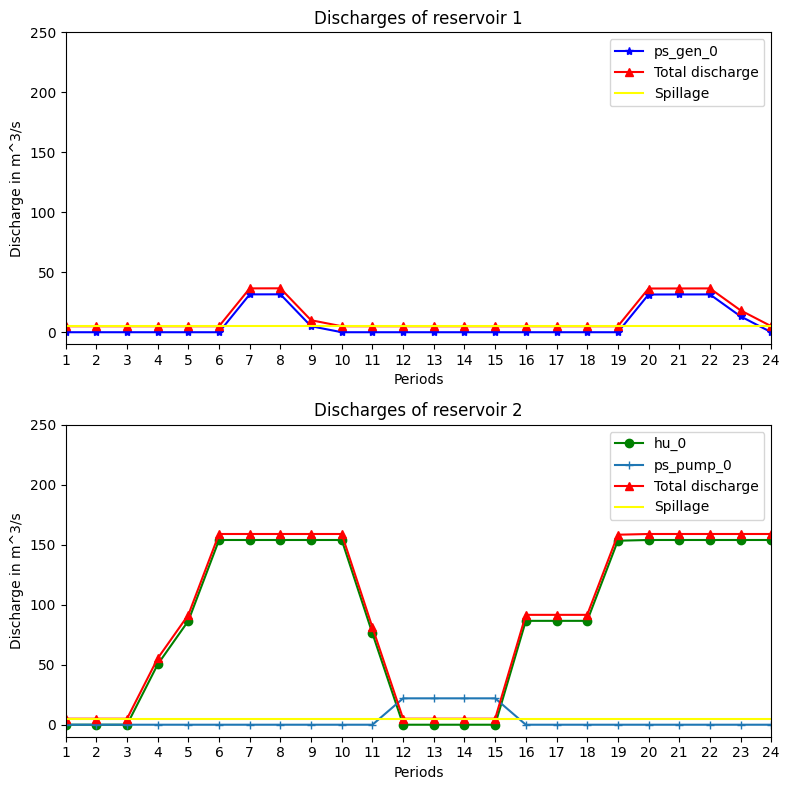

In [48]:
# The first number in the label is always the reservoir index and the second the unit index

fig, ax = plt.subplots(nrows=len(psh.reservoirs)-1, ncols=1, figsize=(8,8))

for i in psh.reservoirs[:-1]:

    # Discharges from hydro units
    for j in psh.hu_affiliation[i]:
        ax[i].plot(psh.periods+1, results.loc[f'hu_discharge_{i}_{j}'], marker='o', label=f'hu_{j}', color='green')

    # Discharges from pumped-storage units to generate power
    for k in psh.ps_affiliation[i]:
        ax[i].plot(psh.periods+1, results.loc[f'ps_discharge_gen_{i}_{k}'], marker='*', label=f'ps_gen_{j}', color='blue')

    # Discharges from pumped-storage units pumped upstream
    if i > 0: # No water can be punped upstream from first reservoir
        for k in psh.ps_affiliation[i-1]:
            ax[i].plot(psh.periods+1, results.loc[f'ps_discharge_pump_{i}_{k}'], marker='+', label=f'ps_pump_{k}')

    # Total discharge downstream and spillage
    ax[i].plot(psh.periods+1, results.loc[f'total_discharge_{i}'], label=f'Total discharge', marker='^', color='red')
    ax[i].plot(psh.periods+1, results.loc[f'spillage_{i}'], label=f'Spillage', color='yellow')

    ax[i].set_title(f'Discharges of reservoir {i+1}')
    ax[i].set_ylabel('Discharge in m^3/s')
    ax[i].set_xlabel('Periods')
    
    ax[i].set_xticks(psh.periods+1)
    ax[i].set_xlim(1, len(psh.periods))
    ax[i].set_ylim(-10, 250)

    ax[i].legend()

plt.tight_layout()

#### Power Output over the Planning Horizon

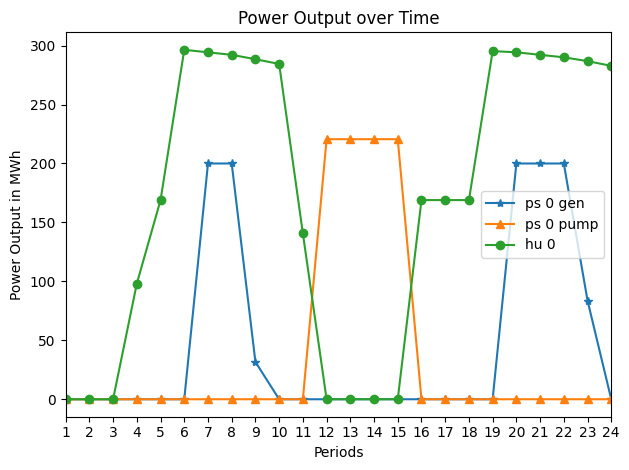

In [49]:
# The first number in the label is always the reservoir index and the second the unit index

fig, ax = plt.subplots()

for i in psh.reservoirs[:-1]:

    # Power generated by hydro units
    for j in psh.hu_affiliation[i]:
        ax.plot(psh.periods+1, results.loc[f'hu_power_{i}_{j}'], label=f'hu {j}', marker='o')
    
    # Power generated and consumed by pumped-storage units
    for k in psh.ps_affiliation[i]:
        ax.plot(psh.periods+1, results.loc[f'ps_power_gen_{i}_{k}'], label=f'ps {k} gen', marker='*')
        ax.plot(psh.periods+1, results.loc[f'ps_power_pump_{i}_{k}'], label=f'ps {k} pump', marker='^')

    ax.set_title('Power Output over Time')
    ax.set_ylabel('Power Output in MWh')
    ax.set_xlabel('Periods')

    ax.set_xticks(psh.periods+1)
    ax.set_xlim(1, len(psh.periods))

    ax.legend()

plt.tight_layout()

#### Power Production and Determinants over the Planning Horizon

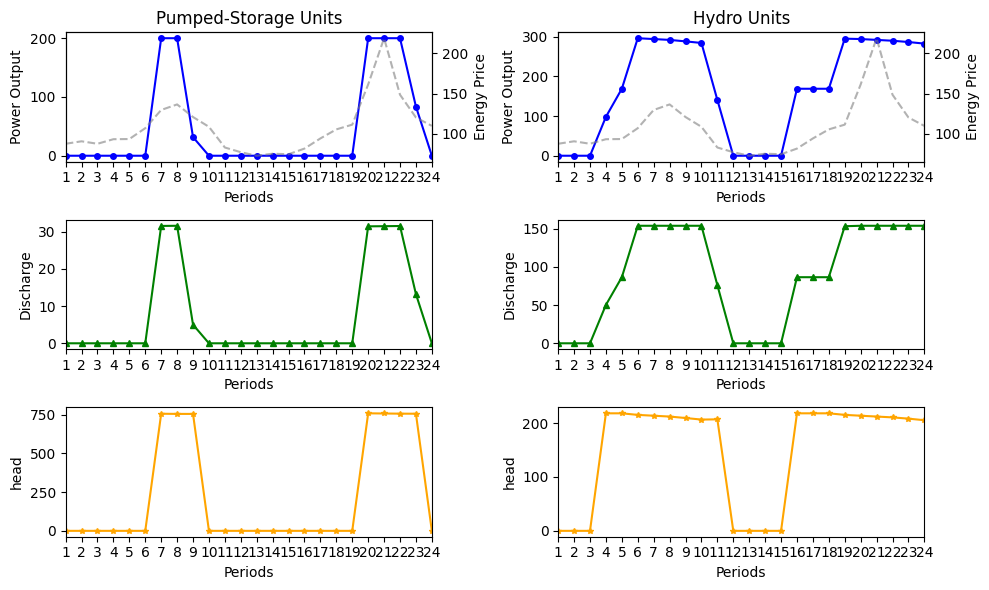

In [56]:
# The first number in the label is always the reservoir index and the second the unit index

fig, ax = plt.subplots(figsize=(10,6), nrows=3, ncols=len(psh.reservoirs)-1)

for i in psh.reservoirs[:-1]:

    # Power, discharge and head of hydro units
    for j in psh.hu_affiliation[i]:
        ax[0,i].plot(psh.periods+1, results.loc[f'hu_power_{i}_{j}'], marker='o', markersize=4, label='Hydro Unit Power Output', color='blue')
        ax2 = ax[0,i].twinx()
        ax2.plot(psh.periods+1, psh.projected_prices, linestyle='--', color='gray', alpha=0.6)
        ax2.set_ylabel('Energy Price')
        ax[1,i].plot(psh.periods+1, results.loc[f'hu_discharge_{i}_{j}'], marker='^', markersize=4, label='Hydro Unit Discharge', color='green')
        ax[2,i].plot(psh.periods+1, results.loc[f'hu_head_{i}_{j}'], marker='*', markersize=4, label='Hydro Unit Head', color='orange')

    # Power, discharge and head of pumped-storage units
    for k in psh.ps_affiliation[i]:
        ax[0,i].plot(psh.periods+1, results.loc[f'ps_power_gen_{i}_{k}'], marker='o', markersize=4, label='Pumped-Storage Unit Power Output', color='blue')
        ax2 = ax[0,i].twinx()
        ax2.plot(psh.periods+1, psh.projected_prices, linestyle='--', color='gray', alpha=0.6)
        ax2.set_ylabel('Energy Price')
        ax[1,i].plot(psh.periods+1, results.loc[f'ps_discharge_gen_{i}_{k}'], marker='^', markersize=4, label='Pumped-Storage Unit Discharge', color='green')
        ax[2,i].plot(psh.periods+1, results.loc[f'ps_head_{i}_{k}'], marker='*', markersize=4, label='Pumped-Storage Unit Head', color='orange')
    
    ax[0,i].set_ylabel('Power Output')
    ax[1,i].set_ylabel('Discharge')
    ax[2,i].set_ylabel('head')

    for x in range(3):
        ax[x,i].set_xlabel('Periods')
        ax[x,i].set_xticks(psh.periods+1)
        ax[x,i].set_xlim(1, len(psh.periods))
    
    ax[0,0].set_title('Pumped-Storage Units')
    ax[0,1].set_title('Hydro Units')

    plt.tight_layout()
    plt.savefig('Images/power_output.png')


#### Power Output for each Energy Price

Text(0.5, 0, 'Projected Price')

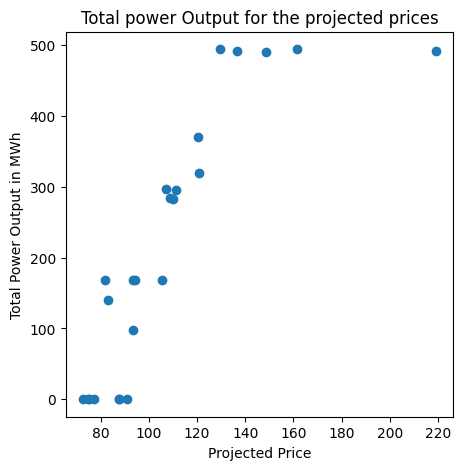

In [51]:
fig, ax = plt.subplots(figsize=(5,5))

power = []

for t in psh.periods:
    power_sum = 0 # power output is summed up over all hydro units and pumped-storage units
    for i in psh.reservoirs:

        # Adding output of hydro units
        for j in psh.hu_affiliation[i]:
            power_sum += psh.hu_power[i,j,t].solution_value

        # Adding output of pumped-storage units
        for k in psh.ps_affiliation[i]:
            power_sum += psh.ps_power_gen[i,k,t].solution_value

    power.append(power_sum)

ax.scatter(psh.projected_prices, power)

ax.set_title('Total power Output for the projected prices')
ax.set_ylabel('Total Power Output in MWh')
ax.set_xlabel('Projected Price')

#### Volume, Inflows and Outflows from and to Reservoirs

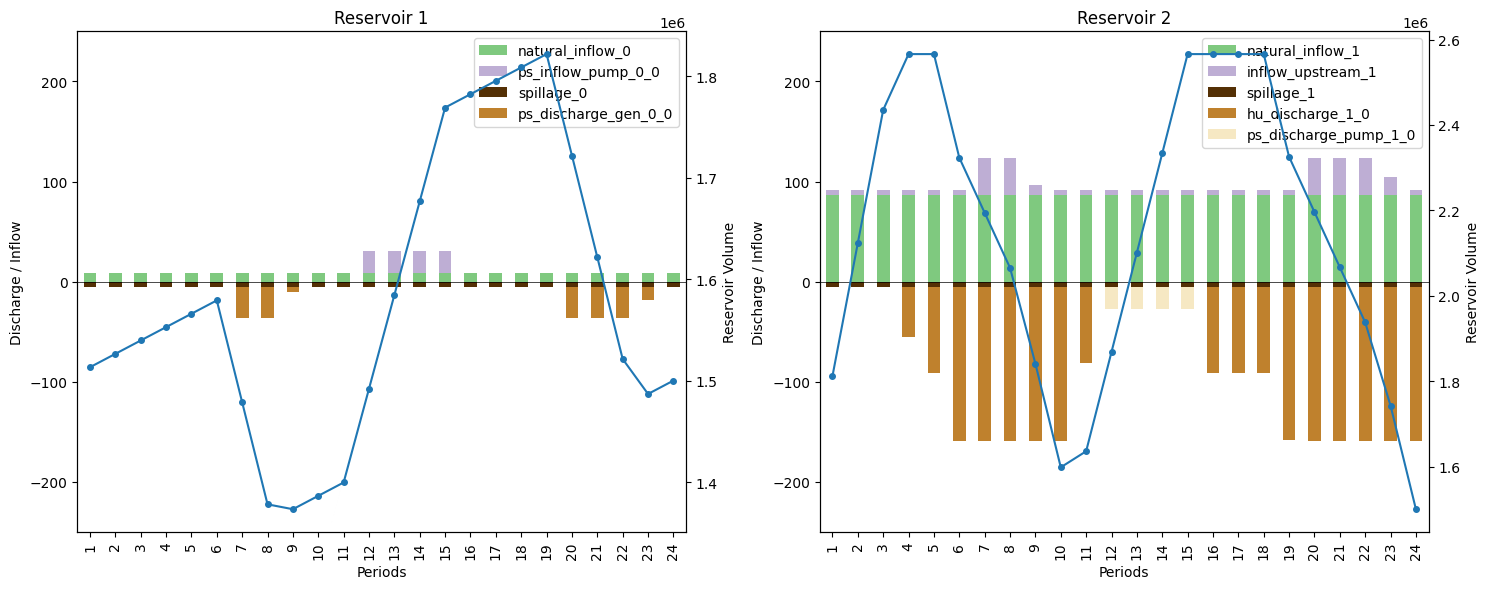

In [52]:
# The first number in the label is always the reservoir index and the second the unit index

fig, ax = plt.subplots(figsize=(15,6), ncols=len(psh.reservoirs)-1)

for i in psh.reservoirs[:-1]:

    # Creating a new data frame with inflows (positive)
    results_filtered_pos = pd.DataFrame()

    # Natural inflows
    results_filtered_pos[f'natural_inflow_{i}'] = results.loc[f'natural_inflow_{i}']

    # Water pumped upstream
    for k in psh.ps_affiliation[i]:
        results_filtered_pos[f'ps_inflow_pump_{i}_{k}'] = results.loc[f'ps_inflow_pump_{i}_{k}']

    # Inflows from upstream reservoirs
    if i > 0:
        results_filtered_pos[f'inflow_upstream_{i}'] = results.loc[f'inflow_upstream_{i}']

    # Adjusting index
    results_filtered_pos.index = psh.periods+1

    # Creating a new data frame with outflows (negative)
    results_filtered_neg = pd.DataFrame()

    # Spillage
    results_filtered_neg[f'spillage_{i}'] = results.loc[f'spillage_{i}']

    # Outflows by hydro units
    for j in psh.hu_affiliation[i]:
        results_filtered_neg[f'hu_discharge_{i}_{j}'] = results.loc[f'hu_discharge_{i}_{j}']

    # Outflows by pumped-storage units to generate power
    for k in psh.ps_affiliation[i]:
        results_filtered_neg[f'ps_discharge_gen_{i}_{k}'] = results.loc[f'ps_discharge_gen_{i}_{k}']

    # Outflows pumped upstream by pumped-storage units
    if i > 0:
        for k in psh.ps_affiliation[i-1]:    
            results_filtered_neg[f'ps_discharge_pump_{i}_{k}'] = results.loc[f'ps_discharge_pump_{i}_{k}']
    
    # Multiplying dataframe with -1 to get negative values and adjusting the index
    results_filtered_neg = results_filtered_neg * (-1)
    results_filtered_neg.index = psh.periods+1

    # Adding coloring
    colormap = plt.get_cmap('Accent')
    colors_pos = colormap(np.arange(0,1,0.2))
    colormap = plt.get_cmap('BrBG')
    colors_neg = colormap(np.arange(0,1,0.2))

    # Plotting in- and outflows
    results_filtered_pos.plot(kind='bar', stacked=True, ax=ax[i], color=colors_pos)
    results_filtered_neg.plot(kind='bar', stacked=True, ax=ax[i], color=colors_neg)
    ax[i].axhline(y=0, color='black', linewidth=0.5)

    ax[i].set_ylim(-250, 250)
    
    # Plotting the volume
    ax2 = ax[i].twinx()
    results.T[f'volume_{i}'].plot(kind='line', ax=ax2, marker='o', markersize=4)

    ax[i].set_title(f'Reservoir {i+1}')
    ax[i].set_ylabel('Discharge / Inflow')
    ax2.set_ylabel('Reservoir Volume')
    ax[i].set_xlabel('Periods')

    plt.tight_layout()

plt.savefig('Images/Volume.png')

## Numerical Study

#### Varying accuracy by changig the number of subregions

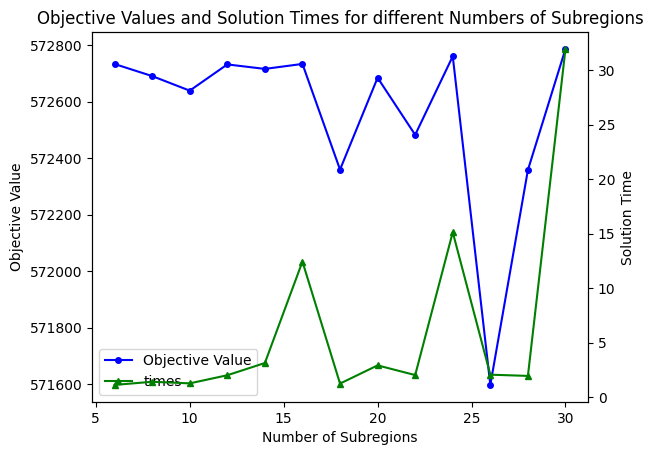

<Figure size 640x480 with 0 Axes>

In [14]:
# Defining empty lists
objectice_values = []
times = []

# Defining values for sensitivity analysis
values_subregions = np.arange(6,31,2)

for l in values_subregions:

    # Creating a model instance
    psh_subregions = PSH()

    # Defining number of subregions and solving the model
    psh_subregions.subregions = np.arange(l)

    # Calculating the vertices
    psh_subregions.hu_h_vertices = psh_subregions.head_vertices(psh_subregions.hydro_units, psh_subregions.hu_affiliation, psh_subregions.hu_head_limits)
    psh_subregions.hu_q_vertices = psh_subregions.discharge_vertices(psh_subregions.hydro_units, psh_subregions.hu_affiliation, psh_subregions.hu_discharge_limits)
    psh_subregions.hu_p_vertices = psh_subregions.power_vertices(psh_subregions.hydro_units, psh_subregions.hu_affiliation, psh_subregions.hu_h_vertices, psh_subregions.hu_q_vertices, psh_subregions.hu_effciency)

    psh_subregions.ps_h_vertices = psh_subregions.head_vertices(psh_subregions.pumped_storage_units, psh_subregions.ps_affiliation, psh_subregions.ps_head_limits)
    psh_subregions.ps_q_vertices = psh_subregions.discharge_vertices(psh_subregions.pumped_storage_units, psh_subregions.ps_affiliation, psh_subregions.ps_discharge_generation_limits)
    psh_subregions.ps_p_vertices = psh_subregions.power_vertices(psh_subregions.pumped_storage_units, psh_subregions.ps_affiliation, psh_subregions.ps_h_vertices, psh_subregions.ps_q_vertices, psh_subregions.ps_efficiency_gen)

    # Defining decision variables and constraints
    psh_subregions.define_decision_variables()
    psh_subregions.define_contraints()

    # Solving the model
    psh_subregions.solve_model()

    # Saving results
    objectice_values.append(psh_subregions.objective_value)
    times.append(psh_subregions.solve_details.time)

# Plotting the results
fig, ax = plt.subplots()
ax.plot(values_subregions, objectice_values, marker='o', markersize=4, label='Objective Value', color='blue')
ax2 = ax.twinx()
ax2.plot(values_subregions, times, marker='^', markersize=4, label='times', color='green')

ax.set_title('Objective Values and Solution Times for different Numbers of Subregions')
ax.set_ylabel('Objective Value')
ax.set_xlabel('Number of Subregions')
ax2.set_ylabel('Solution Time')

lines = ax.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax.legend(lines, labels)

plt.show()
plt.savefig('Images/subregions.png')

# Showing the results in a table
subregion_sensitivity = pd.DataFrame(index=['Objective Value', 'Solution Time'], columns=values_subregions)
subregion_sensitivity.loc['Objective Value':,] = objectice_values
subregion_sensitivity.loc['Solution Time':,] = times
subregion_sensitivity

#### Varying initial and terminal volumes

In [17]:
# Defining values for the sensitivity analysis
initial_volumes_1 = np.linspace(psh.volume_limits.loc['min',0], psh.volume_limits.loc['max',0], 4)
initial_volumes_2 = np.linspace(psh.volume_limits.loc['min',1], psh.volume_limits.loc['max',1], 4) 

# Defining empty lists
objectice_values = pd.DataFrame(index=initial_volumes_1, columns=initial_volumes_2)
periods_pumping_state = pd.DataFrame(index=initial_volumes_1, columns=initial_volumes_2)
times = pd.DataFrame(index=initial_volumes_1, columns=initial_volumes_2)

for initial_volume_1 in initial_volumes_1:
    for initial_volume_2 in initial_volumes_2:

        # Creating a model instance
        psh_initial = PSH()

        # Setting the initial volumes
        psh_initial.initial_volume[0] = initial_volume_1
        psh_initial.initial_volume[1] = initial_volume_2

        # Calculating the vertices
        psh_initial.hu_h_vertices = psh_initial.head_vertices(psh_initial.hydro_units, psh_initial.hu_affiliation, psh_initial.hu_head_limits)
        psh_initial.hu_q_vertices = psh_initial.discharge_vertices(psh_initial.hydro_units, psh_initial.hu_affiliation, psh_initial.hu_discharge_limits)
        psh_initial.hu_p_vertices = psh_initial.power_vertices(psh_initial.hydro_units, psh_initial.hu_affiliation, psh_initial.hu_h_vertices, psh_initial.hu_q_vertices, psh_initial.hu_effciency)

        psh_initial.ps_h_vertices = psh_initial.head_vertices(psh_initial.pumped_storage_units, psh_initial.ps_affiliation, psh_initial.ps_head_limits)
        psh_initial.ps_q_vertices = psh_initial.discharge_vertices(psh_initial.pumped_storage_units, psh_initial.ps_affiliation, psh_initial.ps_discharge_generation_limits)
        psh_initial.ps_p_vertices = psh_initial.power_vertices(psh_initial.pumped_storage_units, psh_initial.ps_affiliation, psh_initial.ps_h_vertices, psh_initial.ps_q_vertices, psh_initial.ps_efficiency_gen)

        # Defining decision variables and constraints
        psh_initial.define_decision_variables()
        psh_initial.define_contraints()

        # Solving the model
        psh_initial.solve_model()

        # Checking if the pumping capabilities of the pumped-storage units are used
        pumping_state = [psh_initial.ps_state_pump[i,k,t].solution_value for i in psh_initial.reservoirs for k in psh_initial.ps_affiliation[i] for t in psh_initial.periods]
        pumping_state_sum = np.sum(pumping_state)

        # Saving the results
        objectice_values.loc[initial_volume_1,initial_volume_2] = psh_initial.objective_value
        periods_pumping_state.loc[initial_volume_1,initial_volume_2] = pumping_state_sum
        times.loc[initial_volume_1,initial_volume_2] = psh_initial.solve_details.time

In [18]:
objectice_values

,1000000.0,1522000.0,2044000.0,2566000.0
1.000000e+06,378194.245211,412669.339914,446827.244171,481087.311478
1.583333e+06,563078.861439,597385.927001,631679.101014,665901.904457
2.166667e+06,726590.794392,760752.41167,794861.507044,829285.921409
2.750000e+06,890680.449974,924757.009153,959079.170926,993272.800056


In [19]:
periods_pumping_state

,1000000.0,1522000.0,2044000.0,2566000.0
1.000000e+06,3.0,3.0,3.0,3.0
1.583333e+06,0,0,0,0
2.166667e+06,0,0,0,0
2.750000e+06,0,0,0,0


In [20]:
times

,1000000.0,1522000.0,2044000.0,2566000.0
1.000000e+06,0.751468,0.842263,0.752971,0.63058
1.583333e+06,1.949987,1.578559,2.324029,2.403986
2.166667e+06,7.931887,28.508856,0.958517,16.005298
2.750000e+06,115.71296,214.765745,12.192024,13.102577


In [23]:
# Defining values for the sensitivity analysis
terminal_volumes_1 = np.linspace(psh.volume_limits.loc['min',0], psh.volume_limits.loc['max',0], 4)
terminal_volumes_2 = np.linspace(psh.volume_limits.loc['min',1], psh.volume_limits.loc['max',1], 4) 

# Defining empty lists
objectice_values = pd.DataFrame(index=initial_volumes_1, columns=initial_volumes_2)
periods_pumping_state = pd.DataFrame(index=initial_volumes_1, columns=initial_volumes_2)
times = pd.DataFrame(index=terminal_volumes_1, columns=terminal_volumes_2)

for terminal_volume_1 in terminal_volumes_1:
    for terminal_volume_2 in terminal_volumes_2:

        # Creating a model instance
        psh_terminal = PSH()

        # Setting the initial volumes
        psh_terminal.min_terminal_volume[0] = terminal_volume_1
        psh_terminal.min_terminal_volume[1] = terminal_volume_2

        # Calculating the vertices
        psh_terminal.hu_h_vertices = psh_terminal.head_vertices(psh_terminal.hydro_units, psh_terminal.hu_affiliation, psh_terminal.hu_head_limits)
        psh_terminal.hu_q_vertices = psh_terminal.discharge_vertices(psh_terminal.hydro_units, psh_terminal.hu_affiliation, psh_terminal.hu_discharge_limits)
        psh_terminal.hu_p_vertices = psh_terminal.power_vertices(psh_terminal.hydro_units, psh_terminal.hu_affiliation, psh_terminal.hu_h_vertices, psh_terminal.hu_q_vertices, psh_terminal.hu_effciency)

        psh_terminal.ps_h_vertices = psh_terminal.head_vertices(psh_terminal.pumped_storage_units, psh_terminal.ps_affiliation, psh_terminal.ps_head_limits)
        psh_terminal.ps_q_vertices = psh_terminal.discharge_vertices(psh_terminal.pumped_storage_units, psh_terminal.ps_affiliation, psh_terminal.ps_discharge_generation_limits)
        psh_terminal.ps_p_vertices = psh_terminal.power_vertices(psh_terminal.pumped_storage_units, psh_terminal.ps_affiliation, psh_terminal.ps_h_vertices, psh_terminal.ps_q_vertices, psh_terminal.ps_efficiency_gen)

        # Defining decision variables and constraints
        psh_terminal.define_decision_variables()
        psh_terminal.define_contraints()

        # Solving the model
        psh_terminal.solve_model()

        # Checking if the pumping capabilities of the pumped-storage units are used
        pumping_state = [psh_terminal.ps_state_pump[i,k,t].solution_value for i in psh_terminal.reservoirs for k in psh_terminal.ps_affiliation[i] for t in psh_terminal.periods]
        pumping_state_sum = np.sum(pumping_state)

        # Saving the results
        objectice_values.loc[terminal_volume_1,terminal_volume_2] = psh_terminal.objective_value
        periods_pumping_state.loc[terminal_volume_1,terminal_volume_2] = pumping_state_sum
        times.loc[terminal_volume_1,terminal_volume_2] = psh_terminal.solve_details.time

In [24]:
objectice_values

,1000000.0,1522000.0,2044000.0,2566000.0
1.000000e+06,733768.137828,709834.385055,679138.214252,647533.451873
1.583333e+06,572963.872822,548268.574395,518033.909025,485672.861302
2.166667e+06,369050.154796,343385.291962,312415.169369,279850.129968
2.750000e+06,135342.141145,109553.964389,78483.186281,45918.146881


In [25]:
periods_pumping_state

,1000000.0,1522000.0,2044000.0,2566000.0
1.000000e+06,0,0,0,0
1.583333e+06,0,0,0,0
2.166667e+06,5.0,5.0,5.0,5.0
2.750000e+06,13.0,13.0,13.0,13.0


In [26]:
times

,1000000.0,1522000.0,2044000.0,2566000.0
1.000000e+06,1.44208,5.477409,1.274282,8.407088
1.583333e+06,1.728686,1.786514,1.138858,0.975712
2.166667e+06,0.835087,0.813283,0.869552,0.293754
2.750000e+06,1.735684,0.896877,1.04179,0.295154


#### Varying the natural inflows

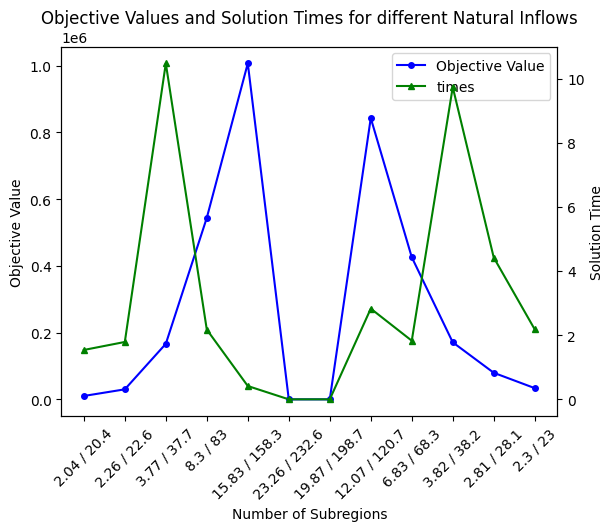

,2.04 / 20.4,2.26 / 22.6,3.77 / 37.7,8.3 / 83,15.83 / 158.3,23.26 / 232.6,19.87 / 198.7,12.07 / 120.7,6.83 / 68.3,3.82 / 38.2,2.81 / 28.1,2.3 / 23
Objective Value,10127.204497,30011.265781,166372.012406,543902.810463,1006680.879602,0,0,842768.998938,425935.827503,170883.147017,79594.172571,33608.305382
Solution Time,1.539318,1.788663,10.474226,2.174626,0.415751,0,0,2.828025,1.828256,9.731935,4.420578,2.181287
Periods Pumping State,4.0,4.0,2.0,0,0,0,0,0,0,2.0,3.0,4.0


<Figure size 640x480 with 0 Axes>

In [43]:
# Defining empty lists
objectice_values = []
times = []
periods_pumping_state = []

# Defining values für the sensitivity analysis
inflows_lower = [20.4, 22.6, 37.7, 83, 158.3, 232.6, 198.7, 120.7, 68.3, 38.2, 28.1, 23] # From hydrological data from nasir et al
inflows_upper = [inflow / 10 for inflow in inflows_lower]

for i in range(len(inflows_lower)):
    
    # Creating a model instance
    psh_inflow = PSH()

    # Setting the initial volumes
    psh_inflow.natural_inflow.loc[0:,] = inflows_upper[i]
    psh_inflow.natural_inflow.loc[1:,] = inflows_lower[i]

    # Calculating the vertices
    psh_inflow.hu_h_vertices = psh_inflow.head_vertices(psh_inflow.hydro_units, psh_inflow.hu_affiliation, psh_inflow.hu_head_limits)
    psh_inflow.hu_q_vertices = psh_inflow.discharge_vertices(psh_inflow.hydro_units, psh_inflow.hu_affiliation, psh_inflow.hu_discharge_limits)
    psh_inflow.hu_p_vertices = psh_inflow.power_vertices(psh_inflow.hydro_units, psh_inflow.hu_affiliation, psh_inflow.hu_h_vertices, psh_inflow.hu_q_vertices, psh_inflow.hu_effciency)

    psh_inflow.ps_h_vertices = psh_inflow.head_vertices(psh_inflow.pumped_storage_units, psh_inflow.ps_affiliation, psh_inflow.ps_head_limits)
    psh_inflow.ps_q_vertices = psh_inflow.discharge_vertices(psh_inflow.pumped_storage_units, psh_inflow.ps_affiliation, psh_inflow.ps_discharge_generation_limits)
    psh_inflow.ps_p_vertices = psh_inflow.power_vertices(psh_inflow.pumped_storage_units, psh_inflow.ps_affiliation, psh_inflow.ps_h_vertices, psh_inflow.ps_q_vertices, psh_inflow.ps_efficiency_gen)

    # Defining decision variables and constraints
    psh_inflow.define_decision_variables()
    psh_inflow.define_contraints()

    # Solving the model
    solution = psh_inflow.solve_model()

    # Saving the results
    try:
        objectice_values.append(psh_inflow.objective_value)
        times.append(psh_inflow.solve_details.time)

        # Checking if the pumping capabilities of the pumped-storage units are used
        pumping_state = [psh_inflow.ps_state_pump[i,k,t].solution_value for i in psh_inflow.reservoirs for k in psh_inflow.ps_affiliation[i] for t in psh_inflow.periods]
        pumping_state_sum = np.sum(pumping_state)
        periods_pumping_state.append(pumping_state_sum)

    except:
        objectice_values.append(0)
        times.append(0)
        periods_pumping_state.append(0)

# Plotting the results
fig, ax = plt.subplots()

# Defining the x labels as combination from the inflows by the upper and lower reservoirs
x_labels = [f'{round(inflows_upper[n],2)} / {round(inflows_lower[n],2)}' for n in range(len(inflows_lower))]

ax.plot(x_labels, objectice_values, marker='o', markersize=4, label='Objective Value', color='blue')
ax2 = ax.twinx()
ax2.plot(x_labels, times, marker='^', markersize=4, label='times', color='green')

ax.set_title('Objective Values and Solution Times for different Natural Inflows')
ax.set_ylabel('Objective Value')
ax.set_xlabel('Natural Inflows')
ax2.set_ylabel('Solution Time')
ax.tick_params(axis='x', labelrotation=45)

lines = ax.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax.legend(lines, labels)

plt.show()
plt.savefig('Images/inflows.png')

# Showing the results in a table
inflow_sensitivity = pd.DataFrame(index=['Objective Value', 'Solution Time', 'Periods Pumping State'], columns=x_labels)
inflow_sensitivity.loc['Objective Value':,] = objectice_values
inflow_sensitivity.loc['Solution Time':,] = times
inflow_sensitivity.loc['Periods Pumping State':,] = periods_pumping_state
inflow_sensitivity

#### Varying the spillage

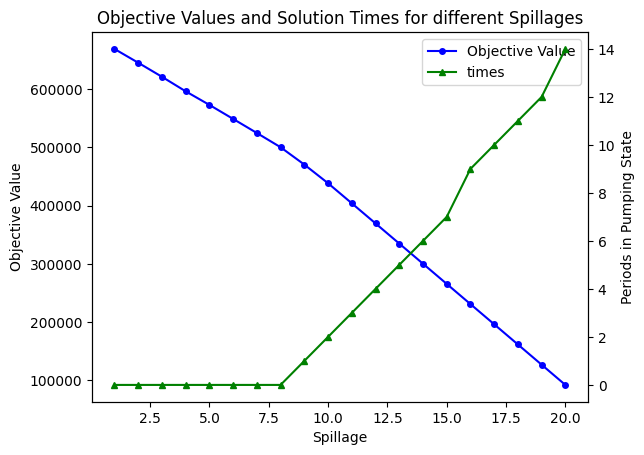

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Objective Value,668629.158943,644967.558593,620880.801627,595947.965692,572639.160786,548608.103784,524440.135894,500009.142166,470277.63521,438300.037282,403918.154726,369398.947721,334844.914767,300264.384527,265642.733181,231010.88061,196393.342014,161729.08578,127039.071222,92347.271546
Solution Time,1.271412,3.1291,2.756662,1.288479,1.395144,1.674421,1.594809,1.400128,9.043737,0.853453,0.979478,0.869316,0.813547,0.904622,1.249227,1.269088,1.436949,1.186301,0.98617,0.94195
Periods Pumping State,0,0,0,0,0,0,0,0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,9.0,10.0,11.0,12.0,14.0


<Figure size 640x480 with 0 Axes>

In [51]:
# Defining empty lists
objectice_values = []
times = []
periods_pumping_state = []

# Defining values for the sensitvity analysis
spillages = np.arange(1,21,1)

for spillage in spillages:

    # Creating a model instance
    psh_spillage = PSH()

    # Setting the initial volumes
    psh_spillage.spillage = pd.DataFrame(data=spillage, index=psh_spillage.reservoirs, columns=psh_spillage.periods)

    # Calculating the vertices
    psh_spillage.hu_h_vertices = psh_spillage.head_vertices(psh_spillage.hydro_units, psh_spillage.hu_affiliation, psh_spillage.hu_head_limits)
    psh_spillage.hu_q_vertices = psh_spillage.discharge_vertices(psh_spillage.hydro_units, psh_spillage.hu_affiliation, psh_spillage.hu_discharge_limits)
    psh_spillage.hu_p_vertices = psh_spillage.power_vertices(psh_spillage.hydro_units, psh_spillage.hu_affiliation, psh_spillage.hu_h_vertices, psh_spillage.hu_q_vertices, psh_spillage.hu_effciency)

    psh_spillage.ps_h_vertices = psh_spillage.head_vertices(psh_spillage.pumped_storage_units, psh_spillage.ps_affiliation, psh_spillage.ps_head_limits)
    psh_spillage.ps_q_vertices = psh_spillage.discharge_vertices(psh_spillage.pumped_storage_units, psh_spillage.ps_affiliation, psh_spillage.ps_discharge_generation_limits)
    psh_spillage.ps_p_vertices = psh_spillage.power_vertices(psh_spillage.pumped_storage_units, psh_spillage.ps_affiliation, psh_spillage.ps_h_vertices, psh_spillage.ps_q_vertices, psh_spillage.ps_efficiency_gen)

    # Defining decision variables and constraints
    psh_spillage.define_decision_variables()
    psh_spillage.define_contraints()

    # Solving the model
    psh_spillage.solve_model()

    # Saving the Results
    objectice_values.append(psh_spillage.objective_value)
    times.append(psh_spillage.solve_details.time)

    # Checking if the pumping capabilities of the pumped-storage units are used
    pumping_state = [psh_spillage.ps_state_pump[i,k,t].solution_value for i in psh_spillage.reservoirs for k in psh_spillage.ps_affiliation[i] for t in psh_spillage.periods]
    pumping_state_sum = np.sum(pumping_state)
    periods_pumping_state.append(pumping_state_sum)

# Plotting the results
fig, ax = plt.subplots()

ax.plot(spillages, objectice_values, marker='o', markersize=4, label='Objective Value', color='blue')
ax2 = ax.twinx()
ax2.plot(spillages, periods_pumping_state, marker='^', markersize=4, label='Pumping Periods', color='green')

ax.set_title('Objective Values and Solution Times for different Spillages')
ax.set_ylabel('Objective Value')
ax.set_xlabel('Spillage')
ax2.set_ylabel('Periods in Pumping State')

lines = ax.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax.legend(lines, labels)

plt.show()
plt.savefig('Images/spillage.png')

# Showing the results in a table
spillage_sensitivity = pd.DataFrame(index=['Objective Value', 'Solution Time', 'Periods Pumping State'], columns=spillages)
spillage_sensitivity.loc['Objective Value':,] = objectice_values
spillage_sensitivity.loc['Solution Time':,] = times
spillage_sensitivity.loc['Periods Pumping State':,] = periods_pumping_state
spillage_sensitivity